# Exercise 1

Derivation: Starting from the optimal policy form $\pi^*(y|x)$ with a KL penalty, derive step-by-step how inserting this into a pairwise preference likelihood leads to the DPO loss. Show how the unknown true reward $r(x,y)$ cancels out, yielding a purely probability-based objective. This derivation cements the intuition that DPO “makes the reward model unnecessary.”

## Solution

### 0. Setup: Notation and Assumptions
 
 **Key Variables**
 | Symbol | Meaning |
 |--------|---------|
 | $x$ | Prompt or context (the "state") |
 | $y \in \mathcal{Y}$ | A complete response (sequence of tokens) |
 | $\pi(y \mid x)$ | Policy distribution over completions (i.e., the language model) |
 | $\pi_{\text{ref}}(y \mid x)$ | Fixed reference policy (typically the SFT model) |
 | $r(x, y) \in \mathbb{R}$ | Unknown "true" reward function |
 | $\beta > 0$ | KL regularization strength (similar to inverse temperature) |
 
 *Note: We work at the sequence level throughout—token-level factorization is standard but unnecessary for this derivation.*
 
 **Technical Assumptions**
 
 For each prompt $x$, we assume:
 
 1. **Finite action space:** $\mathcal{Y}$ is finite or countable (for continuous spaces, sums become integrals).
 
 2. **Full reference support:** The reference policy assigns positive probability to all completions:
    $$\pi_{\text{ref}}(y \mid x) > 0 \quad \forall y \in \mathcal{Y}$$
    This guarantees that $\log \pi_{\text{ref}}(y \mid x)$ is always finite, and the KL divergence is well-defined.
 
 3. **Finite normalization:** The partition function is bounded:
    $$Z(x) := \sum_{y} \pi_{\text{ref}}(y \mid x) \exp\bigl(r(x, y) / \beta\bigr) < \infty$$
    This ensures the optimal policy (derived below) is a valid probability distribution.



### 1. Starting point: KL-regularized optimal policy form

We start from the known closed-form optimizer of the KL-regularized objective (derived via Lagrange multipliers):

$$\boxed{\pi^*(y\mid x) = \frac{\pi_{\text{ref}}(y\mid x)\exp\left(\frac{1}{\beta}r(x,y)\right)}{Z(x)}} \tag{1}$$

where

$$\boxed{Z(x)=\sum_{y'} \pi_{\text{ref}}(y'\mid x)\exp\left(\frac{1}{\beta}r(x,y')\right)} \tag{2}$$

This is the “Boltzmann (softmax) form” with base measure $\pi_{\text{ref}}$.



### 2. Express the reward in terms of policy ratios

Take logs of (1). Because $\pi_{\text{ref}}(y\mid x)>0$ and $Z(x)>0$, logs are defined:

$$\log \pi^*(y\mid x) = \log \pi_{\text{ref}}(y\mid x) + \frac{1}{\beta}r(x,y) - \log Z(x). \tag{3}$$

Rearrange (multiply by $\beta$) to isolate $r(x,y)$:

$$\frac{1}{\beta}r(x,y) = \log \pi^*(y\mid x) - \log \pi_{\text{ref}}(y\mid x) + \log Z(x)$$

$$\boxed{r(x,y) = \beta\Big(\log \pi^*(y\mid x) - \log \pi_{\text{ref}}(y\mid x)\Big) + \beta\log Z(x)} \tag{4}$$



### 3. Pairwise preference likelihood model (modeling assumption)

The dataset consists of triples $(x, y^+, y^-)$ where humans preferred $y^+$ over $y^-$ for the same prompt $x$.

**Assumption A (Bradley–Terry / logistic preference model)**
Humans compare two candidates using a latent utility/reward difference plus logistic noise, which implies:

$$\boxed{\mathbb{P}(y^+ \succ y^- \mid x) = \sigma\Big(r(x,y^+) - r(x,y^-)\Big)} \tag{5}$$

where $\sigma(t)=\frac{1}{1+e^{-t}}$.
This is a standard discrete choice model: the probability of preferring $y^+$ is a monotone function of the utility gap.

**Assumption B (i.i.d. comparisons given the model)**
Given the model parameters (here the policy), observed comparisons are conditionally independent across data points, so the dataset likelihood is the product of per-example probabilities.



### 4. Substitute the KL-optimal identity into the preference probability

We now compute the reward difference in (5) using (4).
Start with (4) for $y^+$ and $y^-$:

$$r(x,y^+) = \beta\Big(\log \pi^*(y^+\mid x)-\log \pi_{\text{ref}}(y^+\mid x)\Big) + \beta\log Z(x) \tag{6}$$

$$r(x,y^-) = \beta\Big(\log \pi^*(y^-\mid x)-\log \pi_{\text{ref}}(y^-\mid x)\Big) + \beta\log Z(x) \tag{7}$$

Subtract (7) from (6):

$$r(x,y^+) - r(x,y^-) = \beta\Big[\log \pi^*(y^+\mid x)-\log \pi_{\text{ref}}(y^+\mid x)\Big] - \beta\Big[\log \pi^*(y^-\mid x)-\log \pi_{\text{ref}}(y^-\mid x)\Big] + \beta\log Z(x)-\beta\log Z(x)$$

The $\beta\log Z(x)$ terms cancel because they depend only on $x$, not on $y$.
So:

$$\boxed{r(x,y^+) - r(x,y^-) = \beta\left( \log\frac{\pi^*(y^+\mid x)}{\pi_{\text{ref}}(y^+\mid x)} - \log\frac{\pi^*(y^-\mid x)}{\pi_{\text{ref}}(y^-\mid x)} \right)} \tag{8}$$

Now plug (8) into the preference model (5):

$$\mathbb{P}(y^+ \succ y^- \mid x) = \sigma\left( \beta\left[ \log\frac{\pi^*(y^+\mid x)}{\pi_{\text{ref}}(y^+\mid x)} - \log\frac{\pi^*(y^-\mid x)}{\pi_{\text{ref}}(y^-\mid x)} \right] \right) \tag{9}$$




### 5. Turn the preference probability into a training loss (maximum likelihood)

Given data points $i=1,\dots,N$ with $(x_i, y_i^+, y_i^-)$, Assumption B gives likelihood:

$$\mathcal{L}(\pi^*) = \prod_{i=1}^N \sigma\left( \beta\left[ \log\frac{\pi^*(y_i^+\mid x_i)}{\pi_{\text{ref}}(y_i^+\mid x_i)} - \log\frac{\pi^*(y_i^-\mid x_i)}{\pi_{\text{ref}}(y_i^-\mid x_i)} \right] \right) \tag{10}$$

Maximizing likelihood is equivalent to minimizing negative log-likelihood:

$$\min \sum_{i=1}^N -\log \sigma\left( \beta\left[ \log\frac{\pi^*(y_i^+\mid x_i)}{\pi_{\text{ref}}(y_i^+\mid x_i)} - \log\frac{\pi^*(y_i^-\mid x_i)}{\pi_{\text{ref}}(y_i^-\mid x_i)} \right] \right) \tag{11}$$

**Defining the logit for each example:**
$$g(x,y^+,y^-;\pi) := \beta\left[ \log\frac{\pi(y^+\mid x)}{\pi_{\text{ref}}(y^+\mid x)} - \log\frac{\pi(y^-\mid x)}{\pi_{\text{ref}}(y^-\mid x)} \right] \tag{12}$$

Then (11) is:
$$\min \sum_i -\log \sigma\big(g(x_i,y_i^+,y_i^-;\pi^*)\big) \tag{13}$$



### 6. Replace $\pi^*$ with a parametric policy $\pi_\theta$ (the DPO approximation)

**Assumption C (policy class approximation)**
We train a parametric policy $\pi_\theta$ (e.g., a transformer LM) intended to approximate the KL-regularized optimum:
$$\pi^*(\cdot\mid x)\approx \pi_\theta(\cdot\mid x)$$
We directly optimize the likelihood with $\pi_\theta$ in place of $\pi^*$.
Substitute $\pi_\theta$ into (11):

$$\boxed{\mathcal{L}_{\text{DPO}}(\theta) = -\sum_{i=1}^N \log \sigma\left( \beta\left[ \log\frac{\pi_\theta(y_i^+\mid x_i)}{\pi_{\text{ref}}(y_i^+\mid x_i)} - \log\frac{\pi_\theta(y_i^-\mid x_i)}{\pi_{\text{ref}}(y_i^-\mid x_i)} \right] \right)} \tag{14}$$

**Expectation form over the preference dataset $\mathcal{D}$:**

$$\boxed{\mathcal{L}_{\text{DPO}}(\theta) = -\mathbb{E}_{(x,y^+,y^-)\sim\mathcal{D}} \Big[ \log \sigma\left( \beta\left[ (\log\pi_\theta(y^+\mid x)-\log\pi_{\text{ref}}(y^+\mid x)) - (\log\pi_\theta(y^-\mid x)-\log\pi_{\text{ref}}(y^-\mid x)) \right] \right) \Big]} \tag{15}$$



### 7. Why the reward model becomes unnecessary” 

 1. If the policy is the KL-regularized optimum for some reward $r$, then reward differences are exactly:
 
    $$r(x,y^+) - r(x,y^-) = \beta\left[ \log\frac{\pi^*(y^+\mid x)}{\pi_{\text{ref}}(y^+\mid x)} - \log\frac{\pi^*(y^-\mid x)}{\pi_{\text{ref}}(y^-\mid x)} \right]$$
 
    with no explicit $r$ or $Z(x)$ remaining.

 2. The preference likelihood only needs the difference $r(x,y^+)-r(x,y^-)$. After substitution, that difference is expressed using only policy probabilities and the reference.

 3. Therefore, instead of learning a separate reward model $r_\phi$ and then running PPO against it, the policy can be directly optimized using the probability-based logistic loss (15).

**Caveat (important):** This does not mean “reward does not exist.” It means a separate reward model does not need to be parameterized and trained to obtain an effective objective—because the necessary scalar signal (reward difference) is representable as a log-prob ratio difference relative to $\pi_{\text{ref}}$.

# Exercise 2

Math: Prove that the DPO loss is convex in the model’s logit difference (assume a fixed reference $\pi_{\text{ref}}$). Why is this convexity an appealing property compared to the non-convex PPO objective? (Hint: Logistic loss is convex.)

## Solution

### 1) Define the (scalar) logit-difference variable

Fix a reference policy $\pi_{\text{ref}}$. For a single preference triple $(x, y^+, y^-)$, define the DPO **logit difference** (often viewed as a “margin”):

$$
z := \beta\Big[(\log \pi_\theta(y^+\mid x)-\log \pi_{\text{ref}}(y^+\mid x))-(\log \pi_\theta(y^-\mid x)-\log \pi_{\text{ref}}(y^-\mid x))\Big].
$$

In this exercise, we treat $z\in\mathbb{R}$ as the variable and $\pi_{\text{ref}}$ as fixed.

For one datapoint, the DPO loss is the negative log-likelihood under the logistic preference model:

$$
\ell(z) = -\log \sigma(z),\qquad \sigma(z)=\frac{1}{1+e^{-z}}.
$$

Using $-\log\sigma(z)=\log(1+e^{-z})$, we can write

$$
\boxed{\ell(z)=\log\big(1+e^{-z}\big)} \tag{1}
$$

This is exactly the standard logistic loss for a positive label, so we expect it to be convex in its argument.



### 2) Convexity proof in $z$

A twice-differentiable scalar function is convex iff its second derivative is nonnegative everywhere.

**First derivative.** From (1):

$$
\ell'(z)=\frac{d}{dz}\log(1+e^{-z})
=\frac{1}{1+e^{-z}}\cdot(-e^{-z})
=-\frac{e^{-z}}{1+e^{-z}}\cdot\frac{e^{z}}{e^{z}}
=-\frac{1}{1+e^{z}}.
$$

Since $\frac{1}{1+e^z}=\sigma(-z)$, we have

$$
\boxed{\ell'(z)=-\sigma(-z)}. \tag{2}
$$

**Second derivative.** Differentiate (2). First, we compute $\frac{d}{dz}\sigma(-z)$ explicitly.

Recall $\sigma(u)=\frac{1}{1+e^{-u}}$. Then

$$
\frac{d\sigma}{du}
=\frac{d}{du}(1+e^{-u})^{-1}
=-(1+e^{-u})^{-2}\cdot(-e^{-u})
=\frac{e^{-u}}{(1+e^{-u})^{2}}.
$$

Now substitute $u=-z$ and apply the chain rule $\frac{d}{dz}\sigma(-z)=\frac{d\sigma}{du}\big|_{u=-z}\cdot\frac{du}{dz}$:

$$
\frac{d}{dz}\sigma(-z)
=\frac{e^{-(-z)}}{(1+e^{-(-z)})^{2}}\cdot(-1)
=-\frac{e^{z}}{(1+e^{z})^{2}}.
$$

Finally, rewrite in terms of $\sigma(-z)=\frac{1}{1+e^{z}}$:

$$
\sigma(-z)(1-\sigma(-z))
=\frac{1}{1+e^{z}}\left(1-\frac{1}{1+e^{z}}\right)
=\frac{1}{1+e^{z}}\cdot\frac{e^{z}}{1+e^{z}}
=\frac{e^{z}}{(1+e^{z})^{2}},
$$

so indeed

$$
\boxed{\frac{d}{dz}\sigma(-z)=-\sigma(-z)(1-\sigma(-z))}.
$$

Using this in (2):

$$
\ell''(z)=-\frac{d}{dz}\sigma(-z)=\sigma(-z)(1-\sigma(-z)).
$$

Because $0<\sigma(-z)<1$ for all finite $z$, it follows that

$$
\boxed{\ell''(z)=\sigma(-z)(1-\sigma(-z))>0\quad \forall z\in\mathbb{R}}. \tag{3}
$$

Therefore $\ell$ is **strictly convex** in $z$ (and in the limit $z\to\pm\infty$, the curvature approaches $0$ but never becomes negative).

**Dataset level.** If the total loss is a sum/average over examples, $L(\{z_i\})=\sum_i \ell(z_i)$, then $L$ is convex in the vector $(z_1,\dots,z_N)$ since a sum of convex functions is convex.

**Important nuance.** This convexity is with respect to the scalar(s) $z$, not necessarily with respect to the model parameters $\theta$ (because the map $\theta\mapsto z$ is nonlinear for neural networks).



### 3) Why this is appealing compared to PPO

Convexity in the “right” scalar variable makes the *preference objective itself* well-behaved:

- **Stable, bounded derivatives**: $\ell'(z)\in[-1,0]$ and $0\le\ell''(z)\le 1/4$.
- **A familiar supervised-loss shape**: DPO is essentially logistic regression on a log-probability difference.

By contrast, PPO’s practical objective is typically harder to optimize:

- **On-policy and non-stationary**: the data distribution changes as the policy changes (higher-variance gradients).
- **Clipping / min surrogate**: the objective is piecewise with flat regions, and is not a simple convex function of a single margin-like scalar.
- **Critic coupling**: the policy update depends on an estimated advantage; critic error can distort gradients.
- **Sensitive tuning**: clipping, KL penalties, reward scaling, etc., can make training brittle when mis-tuned.



# Exercise 3


Coding: Implement the DPO loss function and a simple gradient ascent on it for a toy problem. For example, let $\pi_{\text{ref}}$ be a fixed distribution over two outcomes, and simulate some “human” preference data. Show that training $\pi_\theta$ with DPO reliably increases probability of the preferred outcome. Compare this to a PPO-style training on the same data and note any differences in stability (e.g., PPO might oscillate without careful hyperparameters).

## Solution

The smallest setting is used to demonstrate DPO end-to-end.

### Setup (2 actions)

* Actions/outcomes: $a \in {0,1}$
* Fixed reference policy: $\pi_{\text{ref}}(a)$
* Learned policy: $\pi_\theta(a)$

#### 1D parameterization via log-odds (logit)

With two actions, the policy is just a Bernoulli: it is fully determined by $p := \pi_\theta(1)$ since $\pi_\theta(0)=1-p$. Instead of optimizing $p \in (0,1)$ directly, we use an unconstrained scalar $w \in \mathbb{R}$ defined as the log-odds:

$$
w := \log\frac{\pi_\theta(1)}{\pi_\theta(0)} = \log\frac{p}{1-p}.
$$

Solving this for $p$ gives the logistic/sigmoid mapping:

$$
\pi_\theta(1)=p=\sigma(w)=\frac{1}{1+e^{-w}},
\qquad
\pi_\theta(0)=1-\sigma(w).
$$

#### Reference log-odds

Define the same log-odds for the reference policy:

$$
w_{\text{ref}} := \log\frac{\pi_{\text{ref}}(1)}{\pi_{\text{ref}}(0)}.
$$

#### Preference label as a sign

Each datapoint states which action is preferred. Encode it as a sign:

$$
s = +1 \text{if action 1 is preferred},
\qquad
s = -1 \text{if action 0 is preferred}.
$$


### DPO loss (pairwise logistic loss)

For one pair, DPO uses the logistic loss

$$
\ell(z)=-\log\sigma(z)=\log(1+e^{-z}),
$$

where $z$ is the DPO logit-difference.

### The margin becomes 1D

Start from the general DPO logit-difference:

$$
z := \beta\Big[(\log \pi_\theta(y^+)-\log \pi_{\text{ref}}(y^+))-(\log \pi_\theta(y^-)-\log \pi_{\text{ref}}(y^-))\Big].
$$

Because there are only two actions, each comparison is either $(y^+,y^-)=(1,0)$ or $(0,1)$:

- If $(y^+,y^-)=(1,0)$, then

$$
\begin{aligned}
z
&=\beta\Big[(\log \pi_\theta(1)-\log \pi_{\text{ref}}(1))-(\log \pi_\theta(0)-\log \pi_{\text{ref}}(0))\Big]\\
&=\beta\Big[(\log \pi_\theta(1)-\log \pi_\theta(0))-(\log \pi_{\text{ref}}(1)-\log \pi_{\text{ref}}(0))\Big]\\
&=\beta\,(w-w_{\text{ref}}).
\end{aligned}
$$

- If $(y^+,y^-)=(0,1)$, the same algebra flips the sign:

$$
z=-\beta\,(w-w_{\text{ref}}).
$$

Using the label $s\in\{+1,-1\}$ to unify both cases, we get the single clean formula:

$$
\boxed{z=\beta\,s\,(w-w_{\text{ref}})}.
$$

In the code below, we’ll train $w$ with DPO and track $\pi_\theta(1)$ over time. For comparison, we’ll first fit a tiny reward model from the same preference pairs, then run **PPO** on a 1-step, 2-action bandit whose reward comes from that learned reward model and track $\Pr(a=1)$ during training.

In [17]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(0)

beta = 1
p_ref = np.array([0.5, 0.5])      # reference policy over {0,1}
p_prefer_action1 = 0.75           # synthetic "human" prefers action 1 with this prob

w_ref = np.log(p_ref[1] / p_ref[0])

def sigmoid(t):
    t = np.clip(t, -50, 50)
    return 1 / (1 + np.exp(-t))

pi_ref(1) = 0.500
DPO: pi_theta(1) start=0.500 -> end=0.752


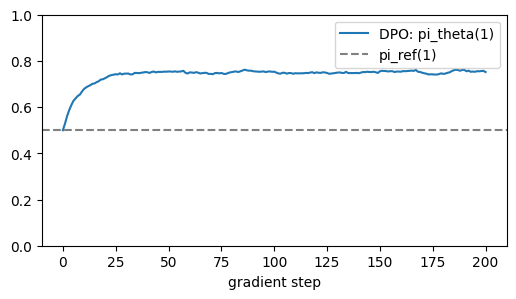

In [18]:

# Preference dataset: s=+1 means "action 1 preferred", s=-1 means "action 0 preferred"
N = 4096
s_data = rng.choice([1, -1], size=N, p=[p_prefer_action1, 1 - p_prefer_action1])

def dpo_loss_and_grad(w, s_batch):
    z = beta * s_batch * (w - w_ref)
    loss = np.mean(np.logaddexp(0.0, -z))          # log(1 + exp(-z))
    dldz = -sigmoid(-z)                            # d/dz log(1+exp(-z))
    dzdw = beta * s_batch                          
    grad = np.mean(dldz * dzdw)        
    return loss, grad

w = 0.0
lr = 0.5
batch_size = 256
steps = 200

dpo_p1 = [sigmoid(w)]
dpo_losses = []

for t in range(steps):
    batch = s_data[rng.integers(0, N, size=batch_size)]
    loss, grad = dpo_loss_and_grad(w, batch)
    w -= lr * grad
    dpo_losses.append(loss)
    dpo_p1.append(sigmoid(w))

print(f"pi_ref(1) = {p_ref[1]:.3f}")
print(f"DPO: pi_theta(1) start={dpo_p1[0]:.3f} -> end={dpo_p1[-1]:.3f}")

plt.figure(figsize=(6, 3))
plt.plot(dpo_p1, label="DPO: pi_theta(1)")
plt.axhline(p_ref[1], linestyle="--", color="gray", label="pi_ref(1)")
plt.ylim(0, 1)
plt.xlabel("gradient step")
plt.legend()
plt.show()





Reward model: r0=0.000, r1=1.087, pref_prob~0.748
PPO: pi(1) start~0.498 -> end~1.000 (estimated)


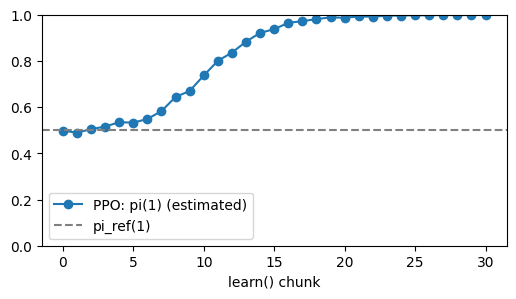

In [19]:
# ----- Reward model from preferences (Bradley-Terry) -----
# Learn reward difference v = r1 - r0 so that P(action1 preferred) = sigmoid(v).
rm_lr = 0.2
rm_steps = 300
rm_batch_size = 256

v = 0.0
rm_losses = []

for _ in range(rm_steps):
    batch = s_data[rng.integers(0, N, size=rm_batch_size)]
    z = batch * v
    loss = np.mean(np.logaddexp(0.0, -z))
    dldz = -sigmoid(-z)
    grad = np.mean(dldz * batch)
    v -= rm_lr * grad
    rm_losses.append(loss)

r0, r1 = 0.0, v
print(f"Reward model: r0={r0:.3f}, r1={r1:.3f}, pref_prob~{sigmoid(v):.3f}")

# ----- PPO (stable-baselines3) on the learned reward model -----

try:
    import gymnasium as gym
    from stable_baselines3 import PPO
    from stable_baselines3.common.vec_env import DummyVecEnv
except Exception:
    import sys, subprocess

    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gymnasium", "stable-baselines3"])

    import gymnasium as gym
    from stable_baselines3 import PPO
    from stable_baselines3.common.vec_env import DummyVecEnv


class TwoArmedRewardModel(gym.Env):
    def __init__(self, r0=0.0, r1=1.0):
        super().__init__()
        self.rewards = np.array([r0, r1], dtype=np.float32)
        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Box(low=-1.0, high=1.0, shape=(1,), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        return np.zeros((1,), dtype=np.float32), {}

    def step(self, action):
        r = float(self.rewards[action])
        obs = np.zeros((1,), dtype=np.float32)
        terminated, truncated = True, False
        return obs, r, terminated, truncated, {}


vec_env = DummyVecEnv([lambda: TwoArmedRewardModel(r0=r0, r1=r1)])

model = PPO(
    "MlpPolicy",
    vec_env,
    verbose=0,
    gamma=0.0,          # bandit (no future rewards)
    n_steps=256,
    batch_size=256,
    learning_rate=3e-4,
    clip_range=0.2,
    seed=0,
)


def estimate_p_action1(model, n=2000):
    obs = vec_env.reset()
    cnt = 0
    for _ in range(n):
        a, _ = model.predict(obs, deterministic=False)
        cnt += int(a[0] == 1)
    return cnt / n


ppo_p1 = [estimate_p_action1(model)]
chunks, chunk_timesteps = 30, 256

for _ in range(chunks):
    model.learn(total_timesteps=chunk_timesteps, reset_num_timesteps=False)
    ppo_p1.append(estimate_p_action1(model))

print(f"PPO: pi(1) start~{ppo_p1[0]:.3f} -> end~{ppo_p1[-1]:.3f} (estimated)")

plt.figure(figsize=(6, 3))
plt.plot(ppo_p1, marker="o", label="PPO: pi(1) (estimated)")
plt.axhline(p_ref[1], linestyle="--", color="gray", label="pi_ref(1)")
plt.ylim(0, 1)
plt.xlabel("learn() chunk")
plt.legend()
plt.show()


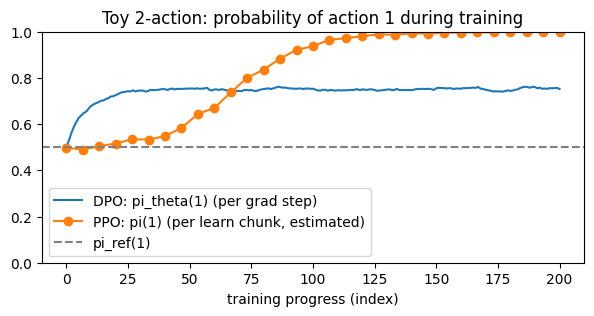

In [20]:
# ----- DPO vs PPO (same plot) -----

plt.figure(figsize=(7, 3))
plt.plot(dpo_p1, label="DPO: pi_theta(1) (per grad step)")

ppo_x = np.linspace(0, len(dpo_p1) - 1, len(ppo_p1))
plt.plot(ppo_x, ppo_p1, marker="o", label="PPO: pi(1) (per learn chunk, estimated)")

plt.axhline(p_ref[1], linestyle="--", color="gray", label="pi_ref(1)")
plt.ylim(0, 1)
plt.xlabel("training progress (index)")
plt.title("Toy 2-action: probability of action 1 during training")
plt.legend()
plt.show()

